In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym

from symbeam import beam
#from sympy.abc import L, E, I, P, M, q, x
from sympy.abc import x

from scipy import interpolate

import ajf_plts

plt.style.use(['./ajf_plts/base.mplstyle',
               './ajf_plts/legend_frame.mplstyle'])

In [2]:
E = 30e9
I = 1.0
L = 20.0
P = 1e3

x_load = np.linspace(0.0, L, 7)

In [3]:
def assemble_beam(L, E, I0, xr, la, delta, depth):
    # print()
    # print(f'xr:{xr} la:{la} L:{L}')
    
    b = beam(L)
    
    b.set_young(0, L, E)
    
    if delta == 0.0:
        Ir = I0
    else:
        lc = 1.5 * depth
        Ir = I0 * (1.0 - (lc/la) * (1.0 - (1.0 - delta)**3.0))
    
    xr_left = xr - 0.5*la
    if xr_left < 0.0:
        xr_left = 0.0

    xr_right = xr + 0.5*la
    if xr_right > L:
        xr_right = L

    if xr_left > 0.0:
        b.set_inertia(0, xr_left, I0)

    b.set_inertia(xr_left, xr_right, Ir)

    if xr_right < L:
        b.set_inertia(xr_right, L, I0)

    # print(f'xr_left:{xr_left} xr_right:{xr_right} Ir:{Ir}')
    
    b.add_support(0, 'pin')
    b.add_support(L, 'roller')
    
    return b

def fit_IL(x_vals, IL_vals, degree=3):
    return interpolate.CubicSpline(x_vals, IL_vals)

def compute_RILs(L, E, I, xr=1.0, lr=0.5, delta=0.0, depth=1.0):
    P=1e3
    
    LHS = []
    RHS = []

    b = assemble_beam(L=L, 
                      E=E, 
                      I0=I, 
                      xr=xr, 
                      la=lr,
                      delta=delta,
                      depth=depth)
    
    for step in x_load:
        b.add_point_load(step, P)
        b.solve(output=False)
        LHS.append(b.segments[0].rotation.subs(x, 0.0))
        RHS.append(b.segments[-1].rotation.subs(x, L))
        # reset beam so we can move point load
        b.point_load_list = []
        b.points = []
        b.segments = []
    
    LHS_fit = fit_IL(x_load, LHS)
    RHS_fit = fit_IL(x_load, RHS)
        
    return LHS_fit, RHS_fit


In [5]:
delta_range = np.linspace(0.0, 0.2, 10)
x_dam_range = np.linspace(0.0, L, 20)
xx, dd = np.meshgrid(x_dam_range, delta_range)

l_dam = 0.1*L

LHS_max_vals = np.zeros_like(xx)
RHS_max_vals = np.zeros_like(xx)

x_interp = np.linspace(0, L, 200)

LHS_H, RHS_H = compute_RILs(L, E, I, delta=0.0)

LHS_max_H = np.max(np.abs(LHS_H(x_interp)))
RHS_max_H = np.max(np.abs(RHS_H(x_interp)))

for ix, iy in np.ndindex(xx.shape):
    x_dam = xx[ix, iy]
    delta = dd[ix, iy]
    
    LHS_IL, RHS_IL = compute_RILs(L, E, I, xr=x_dam, lr=l_dam, delta=delta)
    
    LHS_max_vals[ix, iy] = np.max(np.abs(LHS_IL(x_interp))) - LHS_max_H
    RHS_max_vals[ix, iy] = np.max(np.abs(RHS_IL(x_interp))) - RHS_max_H

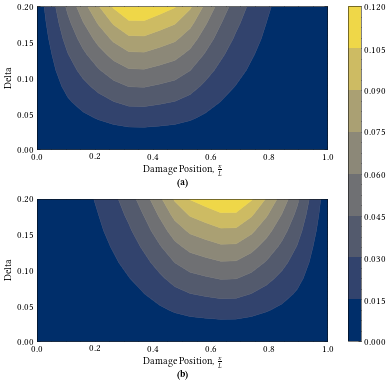

In [6]:
%matplotlib inline

fig, axes = plt.subplots(figsize=(ajf_plts.text_width_inches, 
                                  2.5*ajf_plts.fig_height_inches),
                         nrows=2, ncols=1)


plt.subplot(211)
cnt = plt.contourf(x_dam_range/L, delta_range, LHS_max_vals/LHS_max_H, levels=10)
# This is the fix for the white lines between contour levels
for c in cnt.collections:
    c.set_edgecolor("face")


plt.subplot(212)
#plt.contourf(x_dam_range, delta_range, RHS_max_vals, vmin=1.0, vmax=1.125) # levels=np.linspace(1.0,1.10,100))
cnt = plt.contourf(x_dam_range/L, delta_range, RHS_max_vals/RHS_max_H, levels=10)
# This is the fix for the white lines between contour levels
for c in cnt.collections:
    c.set_edgecolor("face")

for ax in axes:
    ax.set_xlabel(r'Damage Position, $\frac{x}{L}$')
    ax.set_ylabel(r'Delta')
    
ajf_plts.caption_axes(axes)
fig.tight_layout()

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.03, 0.8])
cbar = plt.colorbar(cax=cax) #, ticks=np.linspace(1.0, 1.125, 6))

ajf_plts.save_fig(fig, 'figDamageIndicators.pdf')

In [7]:
minmax_ratio = np.minimum(LHS_max_vals, RHS_max_vals)/np.maximum(LHS_max_vals, RHS_max_vals)

/tmp/ipykernel_8613/2574890833.py:1: RuntimeWarning: invalid value encountered in true_divide
  minmax_ratio = np.minimum(LHS_max_vals, RHS_max_vals)/np.maximum(LHS_max_vals, RHS_max_vals)


In [8]:
x_dam_est = 0.5 + 0.75 * np.where(LHS_max_vals >= RHS_max_vals,
                                  np.cbrt(RHS_max_vals/LHS_max_vals) - 1.0,
                                  1.0 - np.cbrt(LHS_max_vals/RHS_max_vals))

/tmp/ipykernel_8613/3962434521.py:2: RuntimeWarning: invalid value encountered in true_divide
  np.cbrt(RHS_max_vals/LHS_max_vals) - 1.0,
/tmp/ipykernel_8613/3962434521.py:3: RuntimeWarning: invalid value encountered in true_divide
  1.0 - np.cbrt(LHS_max_vals/RHS_max_vals))


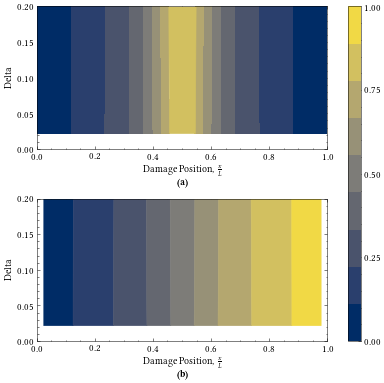

In [9]:
%matplotlib inline

fig, axes = plt.subplots(figsize=(ajf_plts.text_width_inches, 
                                  2.5*ajf_plts.fig_height_inches),
                         nrows=2, ncols=1)

norm = mpl.colors.Normalize(vmin=1.0, vmax=1.125)

plt.subplot(211)
#plt.contourf(x_dam_range, delta_range, LHS_max_vals, vmin=1.0, vmax=1.125) #, levels=np.linspace(1.0, 1.10,100))
cnt = plt.contourf(x_dam_range/L, delta_range, minmax_ratio, levels=np.linspace(0.0, 1.0,10))
# plt.clim(1.0, 1.125)

# This is the fix for the white lines between contour levels
for c in cnt.collections:
    c.set_edgecolor("face")


plt.subplot(212)
# #plt.contourf(x_dam_range, delta_range, RHS_max_vals, vmin=1.0, vmax=1.125) # levels=np.linspace(1.0,1.10,100))
cnt = plt.contourf(x_dam_range/L, delta_range, x_dam_est, levels=np.linspace(0.0,1.0,10))
# # plt.clim(1.0, 1.125)
# 
# This is the fix for the white lines between contour levels
for c in cnt.collections:
    c.set_edgecolor("face")

for ax in axes:
    ax.set_xlabel(r'Damage Position, $\frac{x}{L}$')
    ax.set_ylabel(r'Delta')
    
ajf_plts.caption_axes(axes)
fig.tight_layout()

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.03, 0.8])
cbar = plt.colorbar(cax=cax, ticks=np.linspace(0.0, 1.0, 5))

ajf_plts.save_fig(fig, 'figDamageLocators.pdf')

In [ ]:
xr = 0.333*L
la = 0.075*L

In [ ]:
def assemble_beam(L, E, I0, xr, la, delta, depth):
    print()
    print(f'xr:{xr} la:{la} L:{L}')
    
    b = beam(L)
    
    b.set_young(0, L, E)
    
    if delta == 0.0:
        Ir = I0
    else:
        lc = 1.5 * depth
        Ir = I0 * (1.0 - (lc/la) * (1.0 - (1.0 - delta)**3.0))
    
    xr_left = xr - 0.5*la
    if xr_left < 0.0:
        print('Error 1')
        exit(-1)

    xr_right = xr + 0.5*la
    if xr_right > L:
        print('Error 2')
        exit(-1)

    if xr_left > 0.0:
        b.set_inertia(0, xr_left, I0)

    b.set_inertia(xr_left, xr_right, Ir)

    if xr_right < L:
        b.set_inertia(xr_right, L, I0)

    print(f'xr_left:{xr_left} xr_right:{xr_right} Ir:{Ir}')
    
    b.add_support(0, 'pin')
    b.add_support(L, 'roller')
    
    return b

def compute_RILs(L, E, I, xr, delta, depth=1.0):
    P=1e3
    
    LHS = []
    RHS = []

    b = assemble_beam(L=L, 
                      E=E, 
                      I0=I, 
                      xr=xr, 
                      la=la,
                      delta=delta,
                      depth=depth)
    
    for step in x_load:
        b.add_point_load(step, -P)
        b.solve(output=False)
        LHS.append(b.segments[0].rotation.subs(x, 0.0))
        RHS.append(b.segments[-1].rotation.subs(x, L))
        # reset beam so we can move point load
        b.point_load_list = []
        b.points = []
        b.segments = []
    return LHS, RHS

LHS_H, RHS_H = compute_RILs(L, E, I, xr, delta=0.0)
LHS_D1, RHS_D1 = compute_RILs(L, E, I, xr, delta=0.1)
LHS_D2, RHS_D2 = compute_RILs(L, E, I, xr, delta=0.2)

In [ ]:
def fit_IL(x_vals, IL_vals, degree=3):
    return interpolate.CubicSpline(x_vals, IL_vals)

LHS_H_fit = fit_IL(x_load, LHS_H)
RHS_H_fit = fit_IL(x_load, RHS_H)

LHS_D1_fit = fit_IL(x_load, LHS_D1)
RHS_D1_fit = fit_IL(x_load, RHS_D1)

LHS_D2_fit = fit_IL(x_load, LHS_D2)
RHS_D2_fit = fit_IL(x_load, RHS_D2)

In [ ]:
%matplotlib widget

x_plot = np.linspace(0, L, 200)

marker_props = dict(markersize=2.5, markevery=0.15)
# lhs_marker = dict(marker='o')
# rhs_marker = dict(marker='^')
lhs_marker = dict(marker='')
rhs_marker = dict(marker='')

# find maxima/minima
def annotate_abs_max(ax, fit, color='k'):
    ind = np.argmax(np.abs(fit(x_plot)))
    ax.plot((x_plot/L)[ind], fit(x_plot)[ind]*1e6, color=color, marker='X', markersize=6.0)

    
    
fig, axes = plt.subplots(figsize=(ajf_plts.text_width_inches, 
                                  2.5*ajf_plts.fig_height_inches),
                         nrows=2, ncols=1)

for IL, c, ls in zip([LHS_H_fit, LHS_D1_fit, LHS_D2_fit],
                     ['C0', 'C1', 'C2'],
                     ['-', '--', '-.']):
    axes[0].plot(x_plot/L, IL(x_plot)*1e6, c=c, ls=ls)
    annotate_abs_max(axes[0], IL, color=c)
    
for IL, c, ls in zip([RHS_H_fit, RHS_D1_fit, RHS_D2_fit],
                     ['C0', 'C1', 'C2'],
                     ['-', '--', '-.']):
    axes[1].plot(x_plot/L, IL(x_plot)*1e6, c=c, ls=ls)
    annotate_abs_max(axes[1], IL, color=c)
    

for ax in axes:
    ax.axvspan((xr-0.5*la)/L, (xr+0.5*la)/L, color='0.8')
    ax.set_xlabel(r'Load Position, $\frac{x}{L}$')
    ax.set_ylabel(r'Rotation IL / $\unit{\micro\radian\per\kilo\newton}$')

axes[0].set_ylim([-1.0, 0.0])
axes[1].set_ylim([0.0, 1.0])
    

class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mpl.text.Text(x0, y0, orig_handle)
        handlebox.add_artist(title)
        return title
    
custom_lines = [r'Equivalent $\delta$',
                mpl.lines.Line2D([0], [0], color='C0', ls='-', label='0.0'),
                mpl.lines.Line2D([0], [0], color='C1', ls='--', label='0.1'),
                mpl.lines.Line2D([0], [0], color='C2', ls='-.', label='0.2'),
                '',
                r'IL Abs. Max.',
                mpl.lines.Line2D([0], [0], color='k', ls='', marker='X'),
               ]

ax_fake = fig.add_subplot(111)
ax_fake.set_axis_off()
ax_fake.legend(custom_lines,
          ['', '0.0', '0.1', '0.2', 
           # '', '', 'LHS', 'RHS',
           '', '', r'$\lvert\text{max}(\text{IL})\rvert$'],
          handler_map={str: LegendTitle()},
          loc='center left',
          bbox_to_anchor=(1.025, 0.5))


ajf_plts.caption_axes(axes)
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches),
                         ncols=2, nrows=1,
                         sharex=True, sharey=True)

axes[0].plot(x_plot, LHS_H_fit(x_plot)*1e6)
axes[0].plot(x_plot, LHS_D_fit(x_plot)*1e6)

axes[1].plot(x_plot, RHS_H_fit(x_plot)*1e6)
axes[1].plot(x_plot, RHS_D_fit(x_plot)*1e6)

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()

for i, isegment in enumerate(new_beam.segments):
    rotation_plot = isegment.rotation
    x_start_plot = isegment.x_start
    x_end_plot = isegment.x_end
    
    variables_rotation = rotation_plot.free_symbols
    variables_rotation.discard(x)
    variables_x_start = x_start_plot.free_symbols
    variables_x_start.discard(x)
    variables_x_end = x_end_plot.free_symbols
    variables_x_end.discard(x)
    
    for ivariable in variables_rotation:
        rotation_plot =rotation_plot.subs({ivariable: 1})
    for ivariable in variables_x_start:
        x_start_plot = x_start_plot.subs({ivariable: 1})
    for ivariable in variables_x_end:
        x_end_plot = x_end_plot.subs({ivariable: 1})
    
    # Numerical plotting x variable
    x_plot = np.linspace(
        float(x_start_plot), float(x_end_plot), num=100, endpoint=True
    )
    
    ax.plot(
        x_plot,
        np.vectorize(sym.lambdify(x, rotation_plot))(x_plot),
        c='k'
    )
    

In [ ]:
new_beam.points

In [ ]:
b.segments[0].rotation.subs(x, 0.0)

In [ ]:
b.

In [ ]:
b.length.is_number

In [ ]:
def calc_slope(b):
    rotation_plot = isegment.rotation
    x_start_plot = isegment.x_start
    x_end_plot = isegment.x_end

    variables_rotation = rotation_plot.free_symbols
    variables_rotation.discard(x)
    variables_x_start = x_start_plot.free_symbols
    variables_x_start.discard(x)
    variables_x_end = x_end_plot.free_symbols
    variables_x_end.discard(x)

    for ivariable in variables_rotation:
        rotation_plot =rotation_plot.subs({ivariable: 1})
    for ivariable in variables_x_start:
        x_start_plot = x_start_plot.subs({ivariable: 1})
    for ivariable in variables_x_end:
        x_end_plot = x_end_plot.subs({ivariable: 1})

    # Numerical plotting x variable
    x_plot = np.linspace(
        float(x_start_plot), float(x_end_plot), num=100, endpoint=True
    )

    ax.plot(
        x_plot,
        np.vectorize(sym.lambdify(x, rotation_plot))(x_plot),
        c='k'
    )

In [ ]:
for i, isegment in enumerate(new_beam.segments):
    rotation_plot = isegment.rotation
    x_start_plot = isegment.x_start
    x_end_plot = isegment.x_end
    
    variables_rotation = rotation_plot.free_symbols
    variables_rotation.discard(x)
    variables_x_start = x_start_plot.free_symbols
    variables_x_start.discard(x)
    variables_x_end = x_end_plot.free_symbols
    variables_x_end.discard(x)
    
    for ivariable in variables_rotation:
        rotation_plot =rotation_plot.subs({ivariable: 1})
    for ivariable in variables_x_start:
        x_start_plot = x_start_plot.subs({ivariable: 1})
    for ivariable in variables_x_end:
        x_end_plot = x_end_plot.subs({ivariable: 1})
    
    # Numerical plotting x variable
    x_plot = np.linspace(
        float(x_start_plot), float(x_end_plot), num=100, endpoint=True
    )
    
    ax.plot(
        x_plot,
        np.vectorize(sym.lambdify(x, rotation_plot))(x_plot),
        c='k'
    )
    

In [ ]:
isegment.x_end

In [ ]:
new_beam.point_load_list = []

In [ ]:
for seg in new_beam.segments:
    sym.plotting.plot(seg.rotation)